In [1]:
import pickle as pkl
data = pkl.load(open('favorited_dict3.p', 'rb'))
max_item, max_user = pkl.load(open('useful_stats3.p', 'rb'))
visual_data = pkl.load(open('id_feature_dict_with_artist3_2.p', 'rb'))

In [2]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
removed_items = set()
for key in range(max_item):
    if key not in visual_data:
        removed_items.add(key)
    else:
        if not isinstance(visual_data[key][0], np.ndarray): 
            removed_items.add(key) # for some reason, these are floats. just remove them.

In [5]:
for user in data:
    rated_items = data[user]
    removed = []
    for item in rated_items:
        if item in removed_items:
            removed.append(item)
    for item in removed:
        rated_items.remove(item)
    data[user] = rated_items

In [6]:
users_to_remove = []
for user in data:
    images = np.unique(data[user]).tolist()
    images = [image for image in images if image in visual_data]
    if not images: users_to_remove.append(user)
    else: data[user] = images

for user in users_to_remove:
    data.pop(user)

In [8]:
for key in visual_data:
    visual_data[key] = visual_data[key][0]

In [9]:
def create_validation(data):
    valid = {}
    for key in data:
        rated_items = data[key]
        if len(rated_items) > 1:
            valid[key] = np.random.choice(rated_items)
        else:
            valid[key] = None
    return valid
        

In [10]:
valid = create_validation(data)

In [11]:
def sample_triple(data, valid, nSamples=1):
    samples = np.zeros((nSamples, 3), dtype=int)
    keys = list(data.keys())
    users = np.random.choice(keys, nSamples) 
    samples[:, 0] = users
    
    for i, user in enumerate(tqdm(users)):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        rated_item = np.random.choice(rated_items)
        while rated_item == valid_item:
            rated_item = np.random.choice(rated_items)

        samples[i, 1] = rated_item
        samples[i, 2] = unrated_item
            
    return samples


In [12]:
import math

def sigmoid(x):
    try:
        if type(x) in (int, float, np.float64):
            return 1 / (1 + math.exp(-x))
        else:
            if len(x) == 1:
                x = np.squeeze(x)
                return 1 / (1 + math.exp(-x))
            else:
                return 1 / (1 + np.exp(-x))
    except OverflowError:
        return 0

In [13]:
#hyperparameters
k=10
n=10
lr = 0.5 
lr2 = 0.007
lam_u = .01
lam_bias = .01
lam_rated = .01
lam_unrated = .01
lam_vf = .1
lam_E = .10
lam_vu = .10

sf = 1

In [14]:
item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k), scale=0.1)
latent_users = np.random.normal(size=(max_user, k), scale=0.1)
visual_users = np.random.normal(size=(max_user, n), scale=0.1)
E = np.random.normal(size=(4096, n))
visual_bias = np.random.normal(size=(4096), scale=0.1)

Note that all of the above values are regularized pretty good. The mean value is quite small. But the max visual_user is actually pretty big, so maybe it can use more regularization.

In [15]:
def BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, 
           latent_unrated_item, E, vf_difference, visual_user, visual_bias):
        

    bias_difference = rated_item_bias - unrated_item_bias
    
    if latent_user.ndim == 1:
        latent_difference = np.dot(latent_rated_item - latent_unrated_item, latent_user)
    else:
        latent_difference = np.einsum('ij,ji->i', latent_rated_item - latent_unrated_item, 
                                  np.transpose(latent_user)) 
        
    vf_encoded = np.dot(np.transpose(E), vf_difference)
    visual_difference = np.dot(vf_encoded, visual_user)
    visual_bias_difference = np.dot(vf_difference, visual_bias)
    '''else:
        vf_encoded = np.dot(vf_difference, E)
        visual_difference = np.einsum('ij,ji->i', vf_encoded, np.transpose(visual_user))
        import pdb; pdb.set_trace()
        visual_bias_difference = np.dot(vf_difference, visual_bias[:,None])'''
    return (bias_difference + latent_difference + sf*visual_difference + visual_bias_difference)

In [16]:
def create_valid_dataset(data, valid, nItems=10): #nItems is the number of items not in train/ valid 
    
    valid_list = list(valid.items())
    valid_users = [x[0] for x in valid_list if x[1] is not None]
    valid_items = [x[1] for x in valid_list if x[1] is not None]
    valid_users = np.repeat(valid_users, nItems)
    valid_items = np.repeat(valid_items, nItems)
    
    samples = np.zeros((len(valid_users), 3), dtype=int)
    samples[:, 0] = valid_users
    samples[:, 1] = valid_items
    
    for i, user in enumerate(valid_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        samples[i, 2] = unrated_item
        
    return samples



In [17]:
def AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias):

    samples = create_valid_dataset(data, valid, 5)

    auc = 0.0
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]
        vf_difference = rated_vf-unrated_vf
        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        E, vf_difference, visual_user, visual_bias)

        auc += (br_opt > 0)
    return auc/len(samples)

In [19]:
aucs = []

In [20]:
samples = sample_triple(data, valid, 1000000)
count = 0

'''ib_grads = []
li_grads = []
lu_grads = []
vb_grads = []
vu_grads = []
E_grads = []'''

for user, rated_item, unrated_item in tqdm(samples):

    # ====== Extract out the relevant variables =====
    rated_item_bias = item_biases[rated_item]
    unrated_item_bias = item_biases[unrated_item]
    latent_user = latent_users[user]
    latent_rated_item = latent_items[rated_item]
    latent_unrated_item = latent_items[unrated_item]
    
    visual_user = visual_users[user]
    rated_vf = visual_data[rated_item]
    unrated_vf = visual_data[unrated_item]
    vf_difference = rated_vf-unrated_vf
    # ===============================================


    # ====== Determine the output, i.e. x_uij =======
    br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                    E, vf_difference, visual_user, visual_bias)

    output = sigmoid(-br_opt)
    # ================================================



    # ====== Get Gradients ===========================
    ib_grad = output
    li_grad = output * latent_user
    lu_grad = output * (latent_rated_item-latent_unrated_item)
    E_grad = sf*output * (np.dot((vf_difference)[:,None],visual_user[None,:]))
    vu_grad = sf*output * np.dot(np.transpose(E), vf_difference)
    vb_grad = output * (vf_difference)
    
    '''ib_grads.append(ib_grad)
    li_grads.append(li_grad)
    lu_grads.append(lu_grad)
    vb_grads.append(vb_grad)
    vu_grads.append(vu_grad)
    E_grads.append(E_grad)'''
    # ================================================


    # ====== Update parameters =======================

    item_biases[rated_item] = (1-lr*lam_bias) * rated_item_bias + lr*ib_grad
    item_biases[unrated_item] = (1-lr*lam_bias) * unrated_item_bias - lr*ib_grad

    latent_items[rated_item] = (1-lr*lam_rated) * latent_rated_item + lr*li_grad 
    latent_items[unrated_item] = (1-lr*lam_unrated) * latent_unrated_item - lr*li_grad 

    latent_users[user] = (1-lr*lam_unrated) * latent_user + lr*lu_grad
        
    E = (1-lr2*lam_E) * E + lr2*E_grad

    visual_users[user] = (1-lr2*lam_vu) * visual_user + lr2*vu_grad
    
    visual_bias = (1-lr2*lam_vf)*visual_bias + lr2*vb_grad
    # ================================================



    count += 1
    if count % 1000000 is 0:
        aucs.append(AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias))
    #if count % 100000 is 0: lr = lr/2


999903/|/100%|| 999903/1000000 [14:20<00:00, 1162.48it/s]

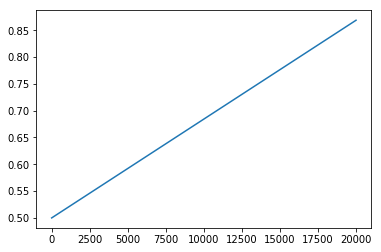

In [21]:
plt.plot(np.array(range(len(aucs)+1))*20000, [0.5]+aucs)

In [22]:
min(aucs)

0.86865580679703946

In [ ]:
plt.figure()
plt.plot(np.array(np.abs(ib_grads[-100:-1])))
plt.plot(np.median(np.abs(np.array(lu_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(li_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(vb_grads)), axis=1)[-100:-1])
plt.plot(np.median(np.abs(np.array(vu_grads), axis=1))[-100:-1])
plt.plot(np.median(np.abs(np.array(E_grads), axis=(1,2)))[-100:-1])

In [ ]:
plt.figure()
plt.plot(np.array(np.abs(ib_grads[:100])))
plt.plot(np.median(np.abs(np.array(lu_grads)), axis=1)[:100])
plt.plot(np.median(np.abs(np.array(li_grads)), axis=1)[:100])
plt.plot(np.median(np.abs(np.array(vb_grads)), axis=1)[:100])
#plt.plot(np.median(np.array(vu_grads), axis=1))
#plt.plot(np.median(np.array(E_grads), axis=(1,2)))

In [ ]:
AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias)

item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k))
latent_users = np.random.normal(size=(max_user, k))
visual_users = np.random.normal(size=(max_user, n))
E = np.random.normal(size=(4096, n))
visual_bias = np.random.normal(size=(4096))

AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias)